In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
from tqdm import tqdm
import seaborn as sns
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction.settings import EfficientFCParameters, ComprehensiveFCParameters
import numpy as np

plt.rcParams['figure.figsize'] = (12, 8)

## <font color=orange>  Helper Functions </font>

In [2]:
# Constants
THRESHOLD_SPRINGBACK = 0.5 # in degrees/section_dim 

def calculateBendingAngleAfterSpringback(df,
                                         threshold   = 1.0,
                                         section_dim = 200,
                                         median      = True):

      """Iterates backwards through dataframe in section_dim rows sections and 
      calculates the difference between the first and the last bending angle of 
      the section. If the difference is greater than threshold, the section is 
      considered as out of final beding angle range and the bending angle after 
      springback is calculated as the median of the after springback range.
      param: 
            df          : DataFrame
            threshold   : increasing rate of bedning angle in degrees/section_dim
            section_dim : section dimension to be considered while iterating.
            median      : True to use a median function on the section, that 
                        is considered as part of springback range.
      return: bending angle after springback
      """
      # drop the rows where at least one element is missing
      df.dropna(inplace=True)
      row = len(df) - 1
      while row > 0:
            if abs(df['Bending_Angle'].iloc[row] - df['Bending_Angle'].iloc[row - section_dim]) > threshold:
                  break
            row -= section_dim
      df_springback = df.iloc[row:]
      if median:
            return df_springback['Bending_Angle'].median()
      else:
            return df_springback['Bending_Angle'].mean()

def extractWorkpieceData(file_path):

      """Extracts data from all csv files in a folder and returns a dataframe 
      param:
            file_path : path to the folder containing the csv files
      return:
            df        : dataframe with the columns: Aluminum, Max_Bending_Angle, 
                        Thickness and Springback.
      """

      # new dataframe
      df_workpiece = pd.DataFrame(columns=['Aluminum','Max_bending_angle', 'Thickness','Springback'])
      springback = []
      material = []
      thickness = []
      max_bending_angle = []

      # extract data from csv files
      files = os.listdir(file_path)
      files = [f for f in files if f.endswith('.csv')]
      for file in tqdm(files):
            df_temp = pd.read_csv(file_path + str(file), sep=';', decimal=',')
            # extract material from file name
            material_value = int(file.split('_')[0])
            material.append(material_value)
            # extract thickness from file name
            thickness_value = int(file.split('_')[1]) / 10
            thickness.append(thickness_value)
            # extract max bending angle from file name
            max_bending_angle.append(int(file.split('_')[2]))
            # calculate springback
            max_bending_angle_value = df_temp['Bending_Angle'].max()
            bending_angle_after_springback = calculateBendingAngleAfterSpringback(df_temp, threshold=THRESHOLD_SPRINGBACK, section_dim=200, median=True)
            springback_value = max_bending_angle_value - bending_angle_after_springback
            springback.append(springback_value)
      # add the values from the lists to dataframe
      df_workpiece['Thickness'] = thickness
      df_workpiece['Springback'] = springback
      df_workpiece['Max_bending_angle'] = max_bending_angle
      # material column is categorical and in order to avoid spurious correlation 
      # between features and prediction due to numerical values, it must be binary
      df_workpiece['Aluminum'] = [1 if x == 1 else 0 for x in material]
      return df_workpiece

def extractForceData(file_path):
      
      """Extracts Force1, Force2, Force3 and Time from every csv file and merges 
      them into one dataframe. Additionaly, each sample is assigned a unique id 
      that corresponds to the index in the workpiece dataframe.
      param:
            file_path : path to the folder containing the csv files
      return:
            df        : dataframe
      """

      #  all force dataframes into one dataframe for tsfresh
      files = os.listdir(file_path)
      files = [f for f in files if f.endswith('.csv')]
      df_forces = pd.DataFrame(columns=['id','Time','Force1','Force2','Force3'])
      id_ = 0
      for file in tqdm(files):
            df_temp = pd.read_csv(file_path + str(file), sep=';', decimal=',')
            df_temp['Time'] = pd.to_datetime(df_temp['Time'])
            df_temp['id'] = id_
            df_forces = pd.concat([df_forces, df_temp[['id','Time','Force1','Force2','Force3']]], ignore_index=True)
            id_ += 1
      # change data type of columns
      df_forces['id'] = df_forces['id'].astype(int)
      df_forces['Force1'] = df_forces['Force1'].astype(float)
      df_forces['Force2'] = df_forces['Force2'].astype(float)
      df_forces['Force3'] = df_forces['Force3'].astype(float)
      return df_forces

## <font color=orange>  1. Data aquisition </font>

In [3]:
training_workpiece_path = "1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/"
test_workpiece_path = "1_Datensatz_Halbzeug_Blechdicke/Testdaten/Messdaten gesamt/"
df_workpiece_training = extractWorkpieceData(training_workpiece_path)
df_workpiece_test = extractWorkpieceData(test_workpiece_path)

100%|██████████| 144/144 [00:11<00:00, 12.11it/s]


In [4]:
trainig_forces_path = '1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten ML/'
test_forces_path = '1_Datensatz_Halbzeug_Blechdicke/Testdaten/Messdaten ML/'
df_forces_training = extractForceData(trainig_forces_path)
df_forces_test = extractForceData(test_forces_path)

100%|██████████| 144/144 [01:05<00:00,  2.20it/s]


## <font color=orange>  2. Data understaning </font>

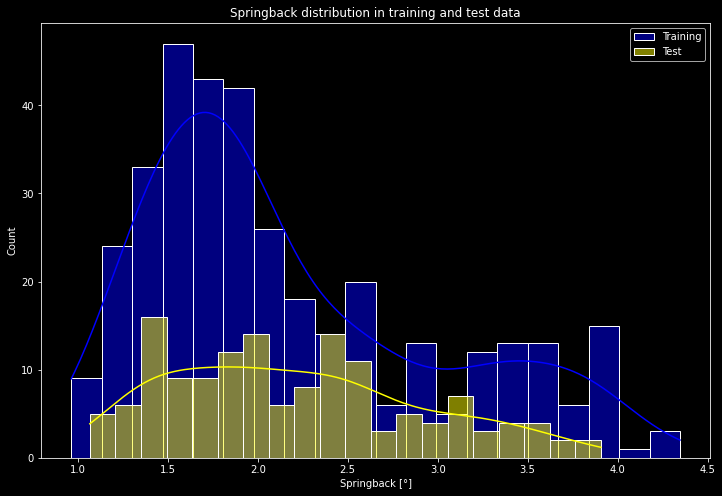

In [25]:
# Distribution of springback values
sns.histplot(df_workpiece_training['Springback'], kde=True, bins=20, label='Training', color='blue')
sns.histplot(df_workpiece_test['Springback'], kde=True, bins=20, label='Test', color='yellow')
plt.xlabel('Springback [°]')
plt.title('Springback distribution in training and test data')
plt.legend()
plt.show()

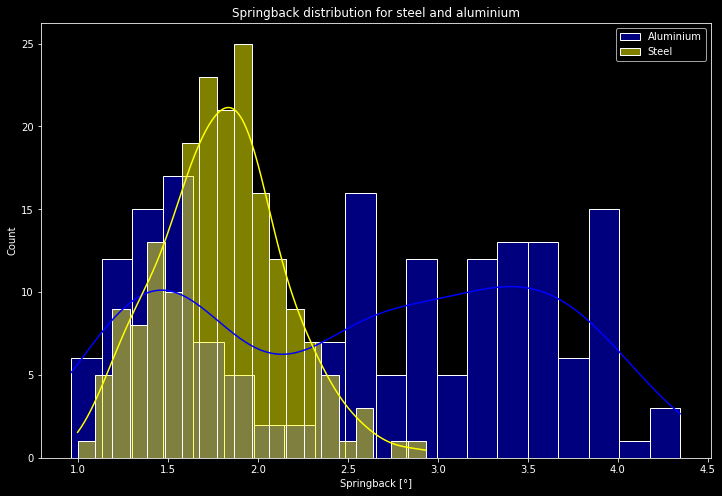

In [24]:
# Distribution of springback values aluminium vs steel
sns.histplot(df_workpiece_training[df_workpiece_training['Aluminum'] == 1]['Springback'], kde=True, bins=20, label='Aluminium', color='blue')
sns.histplot(df_workpiece_training[df_workpiece_training['Aluminum'] == 0]['Springback'], kde=True, bins=20, label='Steel', color='yellow')
plt.xlabel('Springback [°]')
plt.title('Springback distribution for steel and aluminium')
plt.legend()
plt.show()

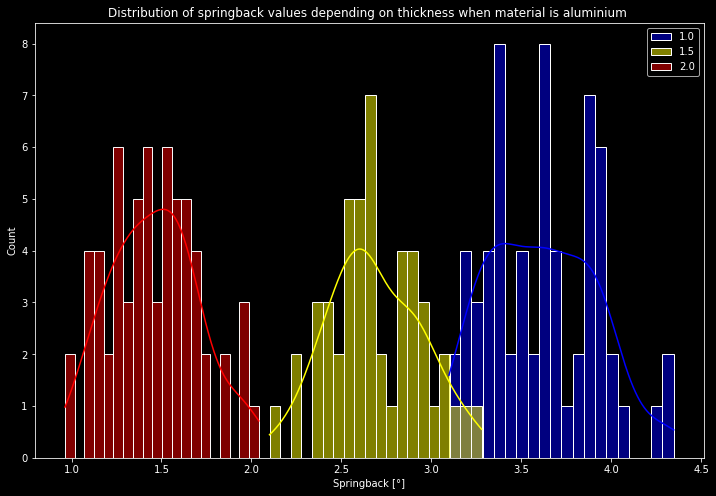

In [23]:
# Distribution of springback values depending on thickness if material is aluminium
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 1.0)]['Springback'], kde=True, bins=20, label='1.0', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 1.5)]['Springback'], kde=True, bins=20, label='1.5', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 2.0)]['Springback'], kde=True, bins=20, label='2.0', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on thickness when material is aluminium ')
plt.legend()
plt.show()

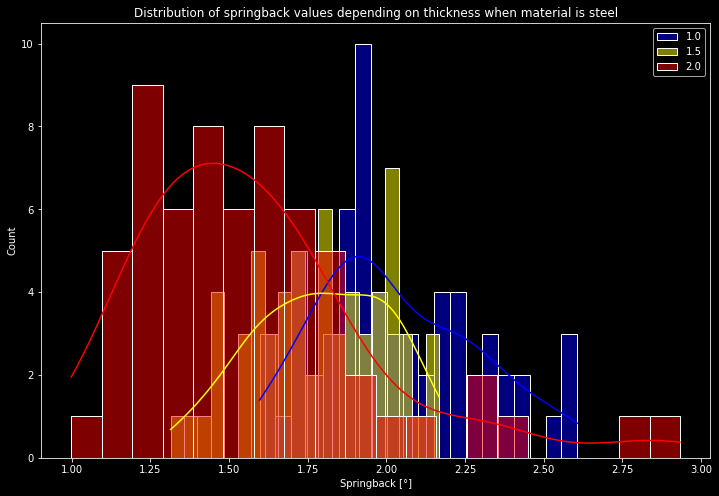

In [22]:
# Distribution of springback values depending on thickness if material is steel
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 1.0)]['Springback'], kde=True, bins=20, label='1.0', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 1.5)]['Springback'], kde=True, bins=20, label='1.5', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 2.0)]['Springback'], kde=True, bins=20, label='2.0', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on thickness when material is steel')
plt.legend()
plt.show()

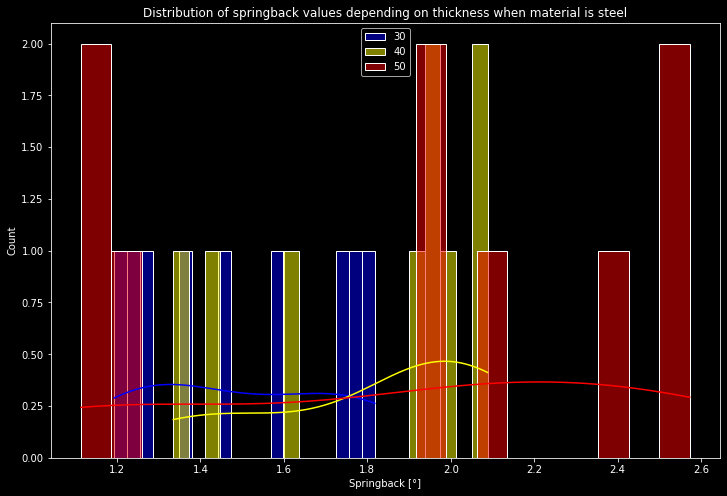

In [29]:
# Distribution of springback values depending on max. bending angle for aluminium
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Max_bending_angle'] == 30)]['Springback'], kde=True, bins=20, label='30', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Max_bending_angle'] == 40)]['Springback'], kde=True, bins=20, label='40', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Max_bending_angle'] == 50)]['Springback'], kde=True, bins=20, label='50', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on max. bending angle when material is aluminium')
plt.legend()
plt.show()

## <font color=orange>  3. Data preprocessing </font>

In [30]:
# features extraction with tsfresh from those three different force curves.
training_features_tsfresh = extract_relevant_features(df_forces_training, 
                                                      df_workpiece_training["Springback"],
                                                      column_id='id', 
                                                      column_sort='Time',
                                                      default_fc_parameters=EfficientFCParameters(),
                                                      n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [16:53<00:00, 50.66s/it]


In [31]:
training_features_tsfresh

,Force2__minimum,"Force2__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)",...,"Force1__fft_coefficient__attr_""real""__coeff_55","Force2__fft_coefficient__attr_""angle""__coeff_33",Force2__index_mass_quantile__q_0.8,Force2__binned_entropy__max_bins_10,Force3__number_peaks__n_3,"Force2__fft_coefficient__attr_""angle""__coeff_20","Force1__fft_coefficient__attr_""real""__coeff_90","Force1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""",Force1__number_peaks__n_10,"Force2__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)"
0,1.750093,1.451504,1.743157,1.752501,1.943533,1.445136,1.955176,1.092355,2.451852,2.464834,...,-13.351059,91.859334,0.803414,1.038579,456.0,105.191867,-1.626990,-0.968686,151.0,-0.110292
1,1.191522,0.874183,1.115979,1.249061,1.346153,1.055572,1.310020,0.809274,0.939464,0.939664,...,14.524742,93.678329,0.817083,1.316679,457.0,103.983534,-1.054527,-0.942331,159.0,0.052599
2,2.668288,1.857089,2.098085,3.244066,3.308085,2.939685,3.064973,2.484132,4.313262,4.308169,...,-1.078185,97.386845,0.806557,1.317909,470.0,98.543445,-2.358291,-0.952035,143.0,-0.030954
3,1.899171,1.501413,1.806171,2.314457,2.430467,2.044972,2.338481,1.687575,2.504291,2.623092,...,4.947808,94.096132,0.804378,1.127125,563.0,97.390106,4.581242,-0.927426,174.0,-0.282100
4,1.674522,1.248992,1.581828,1.797758,1.951561,1.512780,1.922090,1.158426,1.937290,1.972448,...,8.418203,90.453033,0.798603,1.034074,535.0,102.956252,-4.385896,-0.943158,172.0,-0.148994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.474426,4.209738,5.001641,6.663930,6.983379,5.873314,6.666059,4.816260,8.773197,8.864480,...,-8.526283,94.342010,0.802408,1.090710,527.0,108.760224,31.823563,-0.960898,166.0,-0.517686
359,8.132446,4.959477,5.980305,8.171648,8.633432,7.104662,8.284926,5.691524,8.832740,9.050344,...,-11.715103,99.057755,0.805635,0.880035,549.0,110.150926,-24.715808,-0.964603,158.0,-0.792721
360,15.566900,9.177159,11.290998,17.352550,17.776718,15.730784,16.678861,13.329690,22.429048,22.821072,...,-70.784044,98.362463,0.817653,1.331101,638.0,104.010363,23.758032,-0.971254,175.0,-0.194086
361,10.105525,7.184775,8.323663,12.188331,12.676070,10.819101,12.021411,8.909464,15.485918,15.749334,...,-10.088108,96.550197,0.823377,1.315002,630.0,101.480550,52.804788,-0.959097,182.0,-1.012418


In [32]:
# discard the features whose correlation is above 0.95 (redundant features)
print("Number of selected features from tsfresh : " + str(len(list(training_features_tsfresh))) )
corr_matrix = training_features_tsfresh.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
training_features_tsfresh=training_features_tsfresh.drop(training_features_tsfresh[to_drop], axis=1)
print("Number of selected features after removing redundant features : " + str(len(list(training_features_tsfresh))) )

Number of selected features from tsfresh : 1768
Number of selected features after removing highly correlated features : 551


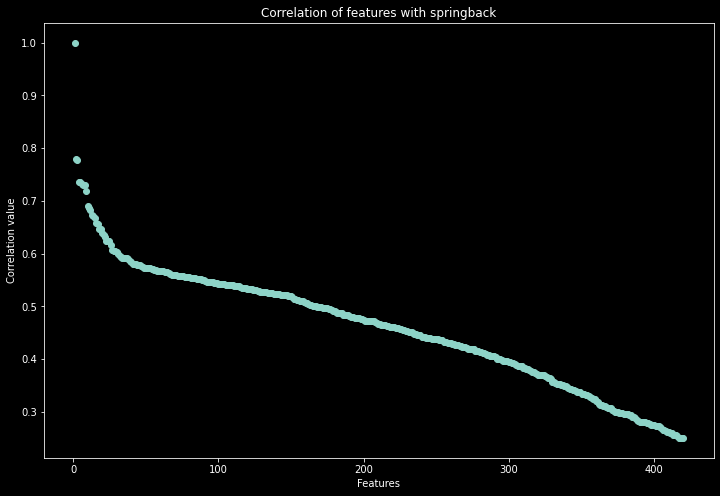

In [38]:
# Correlation of features with springback
training_features_tsfresh["Springback"]=df_workpiece_training["Springback"].values
corr_values=abs(training_features_tsfresh.corrwith(training_features_tsfresh["Springback"])).sort_values(ascending=False)
plt.scatter(np.linspace(1,len(corr_values),len(corr_values)),corr_values)
plt.title("Correlation of features with springback")
plt.xlabel("Features")
plt.ylabel("Correlation value")
plt.show()

In [35]:
# Remove entries with a correlation value below 0.25 with the springback
corr_values=abs(training_features_tsfresh.corrwith(training_features_tsfresh["Springback"]))
to_keep = [column for column in corr_values.index if corr_values[column] > 0.25]
training_features_tsfresh=training_features_tsfresh[to_keep]

In [39]:
training_features_tsfresh

,Force2__minimum,Force1__absolute_maximum,Force3__minimum,Force3__ar_coefficient__coeff_0__k_10,"Force1__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","Force1__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)","Force1__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","Force3__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""",Force1__abs_energy,"Force2__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",...,"Force2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0",Force2__symmetry_looking__r_0.05,"Force2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.0",Force2__partial_autocorrelation__lag_4,Force2__ratio_beyond_r_sigma__r_3,"Force2__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","Force1__fft_coefficient__attr_""real""__coeff_7","Force2__fft_coefficient__attr_""angle""__coeff_25","Force2__fft_coefficient__attr_""angle""__coeff_33",Springback
0,1.750093,5.168843,2.703058,0.171159,0.000304,0.640589,-0.000257,-0.002748,3.655606e+04,-2.793987,...,0.224118,1.0,0.171713,-0.019961,0.033342,-0.498031,118.869463,95.995683,91.859334,3.363434
1,1.191522,5.415735,3.231895,0.196123,0.000396,0.719496,-0.000347,-0.003185,2.462085e+04,-3.868151,...,0.231152,1.0,0.225359,-0.000341,0.023390,-0.432703,150.047545,97.448901,93.678329,3.305664
2,2.668288,4.596850,4.911525,0.153288,0.000376,1.170643,-0.000377,-0.002538,2.486217e+04,-3.846174,...,0.257398,0.0,0.197548,-0.001502,0.027049,-0.479264,111.314027,89.853971,97.386845,3.207978
3,1.899171,4.074218,3.328964,0.153036,0.000295,0.486662,-0.000345,-0.001791,2.152154e+04,-2.917858,...,0.253068,1.0,0.204225,0.000532,0.034101,-0.301564,93.128662,97.211872,94.096132,3.411530
4,1.674522,3.794187,2.597776,0.161958,0.000285,0.648322,-0.000336,-0.001614,2.432697e+04,-3.382060,...,0.200334,1.0,0.186372,-0.026071,0.028427,-0.247106,124.202685,97.848257,90.453033,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.474426,21.434775,12.039614,0.420278,0.000929,3.992659,-0.006059,-0.023401,4.475598e+05,-9.743080,...,0.217628,1.0,0.180801,0.010478,0.023436,-0.331379,-767.598233,99.035628,94.342010,1.536682
359,8.132446,19.131389,8.177114,0.450033,0.000818,1.021651,-0.008879,-0.030855,3.324354e+05,-15.084403,...,0.215165,1.0,0.192978,0.000147,0.021792,-0.288334,-709.924777,104.468524,99.057755,1.892334
360,15.566900,28.216828,23.812704,0.513256,0.001054,10.449694,-0.005805,-0.027102,1.597357e+06,-14.371245,...,0.270840,0.0,0.230457,0.010531,0.018779,-0.327032,-289.132951,103.225444,98.362463,1.146362
361,10.105525,32.405360,17.264938,0.491699,0.001474,9.516471,-0.006045,-0.025580,2.603593e+06,-11.322496,...,0.257913,0.0,0.229267,0.004031,0.022378,-0.327292,-724.859212,99.701283,96.550197,1.199310


In [40]:
# delete Springback column from training_features_tsfresh
training_features_tsfresh.drop(columns=['Springback'], inplace=True)
# join df_workpiece_training and training_features_tsfresh
df_training = training_features_tsfresh.join(df_workpiece_training, how='inner')

In [41]:
print(df_training.corr(method='pearson')['Springback']['Max_bending_angle'])
print(df_training.corr(method='kendall')['Springback']['Max_bending_angle'])
print(df_training.corr(method='spearman')['Springback']['Max_bending_angle'])

0.12986571650077655
0.10062492722498992
0.14160962427648593


In [42]:
# select only features with correlation higher than 0.5
corr_values=abs(df_training.corrwith(df_training["Springback"]))
to_keep = [column for column in corr_values.index if corr_values[column] > 0.60]
df_corr=df_training[to_keep]

In [43]:
df_corr

,Force2__minimum,Force1__absolute_maximum,Force3__minimum,Force3__ar_coefficient__coeff_0__k_10,"Force1__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","Force1__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)","Force3__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","Force2__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Force3__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",Force3__quantile__q_0.1,...,Force1__lempel_ziv_complexity__bins_100,Force1__lempel_ziv_complexity__bins_10,Force1__fourier_entropy__bins_100,Force3__partial_autocorrelation__lag_2,Force3__ar_coefficient__coeff_1__k_10,Force2__ar_coefficient__coeff_1__k_10,"Force2__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""","Force1__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Thickness,Springback
0,1.750093,5.168843,2.703058,0.171159,0.000304,0.640589,-0.002748,-2.793987,-3.451082,13.036575,...,0.397706,0.131502,0.876610,0.282883,0.108123,-0.068643,11.0,17.0,1.0,3.363434
1,1.191522,5.415735,3.231895,0.196123,0.000396,0.719496,-0.003185,-3.868151,-5.633784,14.490687,...,0.391853,0.124573,0.367826,0.282893,0.122385,-0.140243,28.0,26.0,1.0,3.305664
2,2.668288,4.596850,4.911525,0.153288,0.000376,1.170643,-0.002538,-3.846174,-5.736182,13.667230,...,0.395628,0.124044,0.748734,0.321352,0.142026,-0.092488,12.0,18.0,1.0,3.207978
3,1.899171,4.074218,3.328964,0.153036,0.000295,0.486662,-0.001791,-2.917858,-4.956647,11.664089,...,0.390323,0.122811,1.039674,0.380137,0.048453,-0.155568,16.0,17.0,1.0,3.411530
4,1.674522,3.794187,2.597776,0.161958,0.000285,0.648322,-0.001614,-3.382060,-4.473151,11.264267,...,0.394122,0.145025,1.094297,0.352753,0.055610,-0.088625,20.0,17.0,1.0,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.474426,21.434775,12.039614,0.420278,0.000929,3.992659,-0.023401,-9.743080,-15.973867,64.803251,...,0.297570,0.077833,0.136002,0.031808,0.391094,0.071078,32.0,32.0,2.0,1.536682
359,8.132446,19.131389,8.177114,0.450033,0.000818,1.021651,-0.030855,-15.084403,-20.800312,63.619717,...,0.304204,0.081664,0.136002,0.030924,0.403413,0.145274,32.0,32.0,2.0,1.892334
360,15.566900,28.216828,23.812704,0.513256,0.001054,10.449694,-0.027102,-14.371245,-21.275600,90.427434,...,0.271549,0.073427,0.181214,0.015858,0.397424,0.182068,31.0,33.0,2.0,1.146362
361,10.105525,32.405360,17.264938,0.491699,0.001474,9.516471,-0.025580,-11.322496,-20.766741,86.839019,...,0.264102,0.069724,0.136002,0.039667,0.377792,0.204175,33.0,33.0,2.0,1.199310


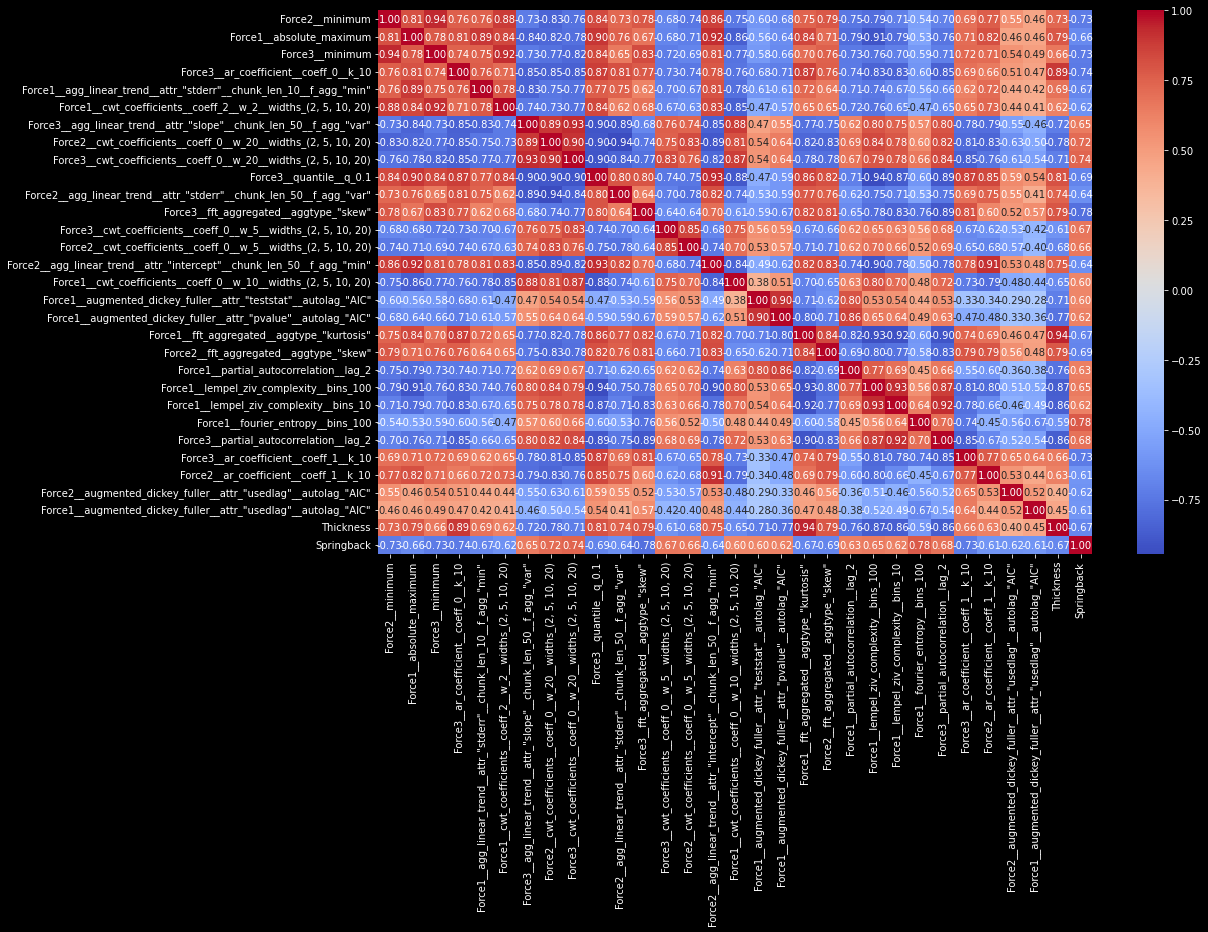

In [44]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_corr.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

## <font color=orange>  4. Model Training </font>

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [45]:
X_train = df_corr.iloc[:, :-1].values
y_train = df_corr.iloc[:, -1].values

In [55]:
#  extract all features from the test data
test_features_tsfresh = extract_features(df_forces_test, 
                                         column_id='id', 
                                         column_sort='Time',
                                         n_jobs=4)


Feature Extraction:  10%|█         | 2/20 [12:10<1:49:30, 365.03s/it]


KeyboardInterrupt: 

In [53]:
# select only the features used for training
df_test = test_features_tsfresh.join(df_workpiece_test, how='inner')

In [54]:
features_training = list(df_corr)
test_features_tsfresh = test_features_tsfresh[features_training]

KeyError: '[\'Force1__fourier_entropy__bins_100\', \'Force2__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"\', \'Force1__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"\', \'Thickness\', \'Springback\'] not in index'

In [50]:
features_training

['Force2__minimum',
 'Force1__absolute_maximum',
 'Force3__minimum',
 'Force3__ar_coefficient__coeff_0__k_10',
 'Force1__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
 'Force1__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)',
 'Force3__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"',
 'Force2__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
 'Force3__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
 'Force3__quantile__q_0.1',
 'Force2__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"',
 'Force3__fft_aggregated__aggtype_"skew"',
 'Force3__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
 'Force2__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
 'Force2__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"',
 'Force1__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
 'Force1__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"',
 'Force1__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"',

In [55]:
parameters = {
    'bootstrap': [True],
    'max_depth': [50, 80],
    'max_features': [2, 5],
    'min_samples_leaf': [4, 6],
    'min_samples_split': [10, 14],
    'n_estimators': [100,300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = parameters,
                           cv = 5, # cross validation split
                           n_jobs = -1, 
                           scoring = 'r2',
                           verbose=1)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
best_estimator=grid_search.best_estimator_
print("Best score: {:.2f}".format(best_score))
print("Best Parameters: ", best_parameters)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best score: 0.86
Best Parameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [56]:
rf = RandomForestRegressor( **best_parameters,
                           oob_score = True,
                           random_state = 0,
                           n_jobs = -1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

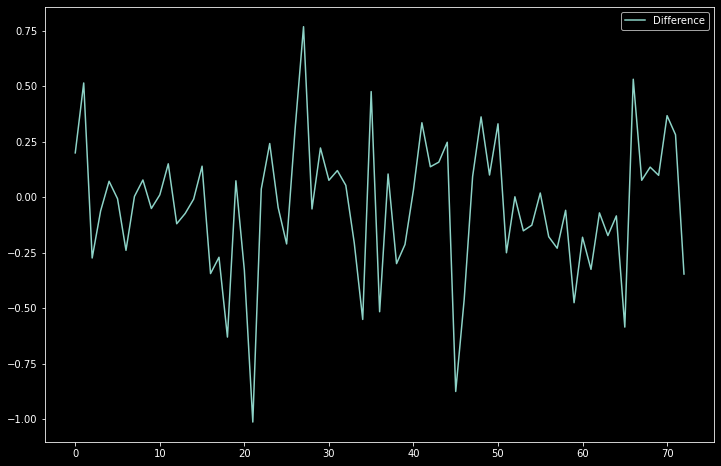

In [66]:
# difference over time
plt.plot(y_pred_rf - y_test, label = 'Difference')
plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

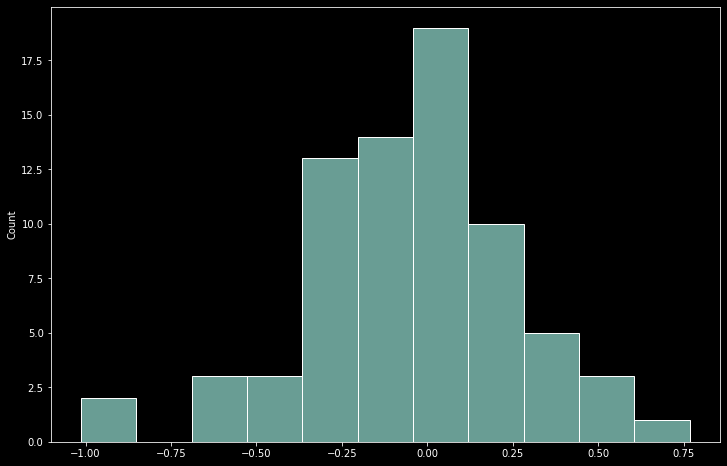

In [67]:
sns.histplot(y_pred_rf - y_test, label = 'Difference')

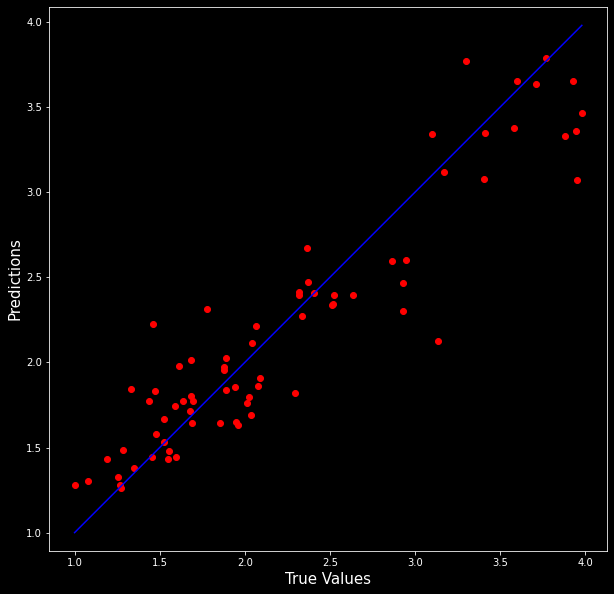

In [57]:
# preadictions over true values
plt.figure(figsize = (10,10))
plt.scatter(y_test, y_pred_rf, c = 'red')

p1 = max(max(y_pred_rf), max(y_test))
p2 = min(min(y_pred_rf), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

## <font color=orange>  Fragen </font>
* Biegewinkel am Ende oder Rückfederung?

## <font color=orange>  Morphological analysis </font>
<table>
  <tr>
    <th>X</th>
    <th>Alternative solution 1</th>
    <th>Alternative solution 2</th>
  </tr>
  <tr>
    <td>Libraries</td>
    <td>Tensorflow</td>
    <td>Pytorch</td>
  </tr>
  <tr>
    <td>Material variation</td>
    <td>Aluminium and steel together</td>
    <td>Aluminium and steel separately</td>
  </tr>
  <tr>
    <td>Independent variable</td>
    <td>Springback</td>
    <td>Bending angle after springback</td>
  </tr>
</table>